<a href="https://colab.research.google.com/github/txusser/Master_IA_Sanidad/blob/main/NN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do much of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

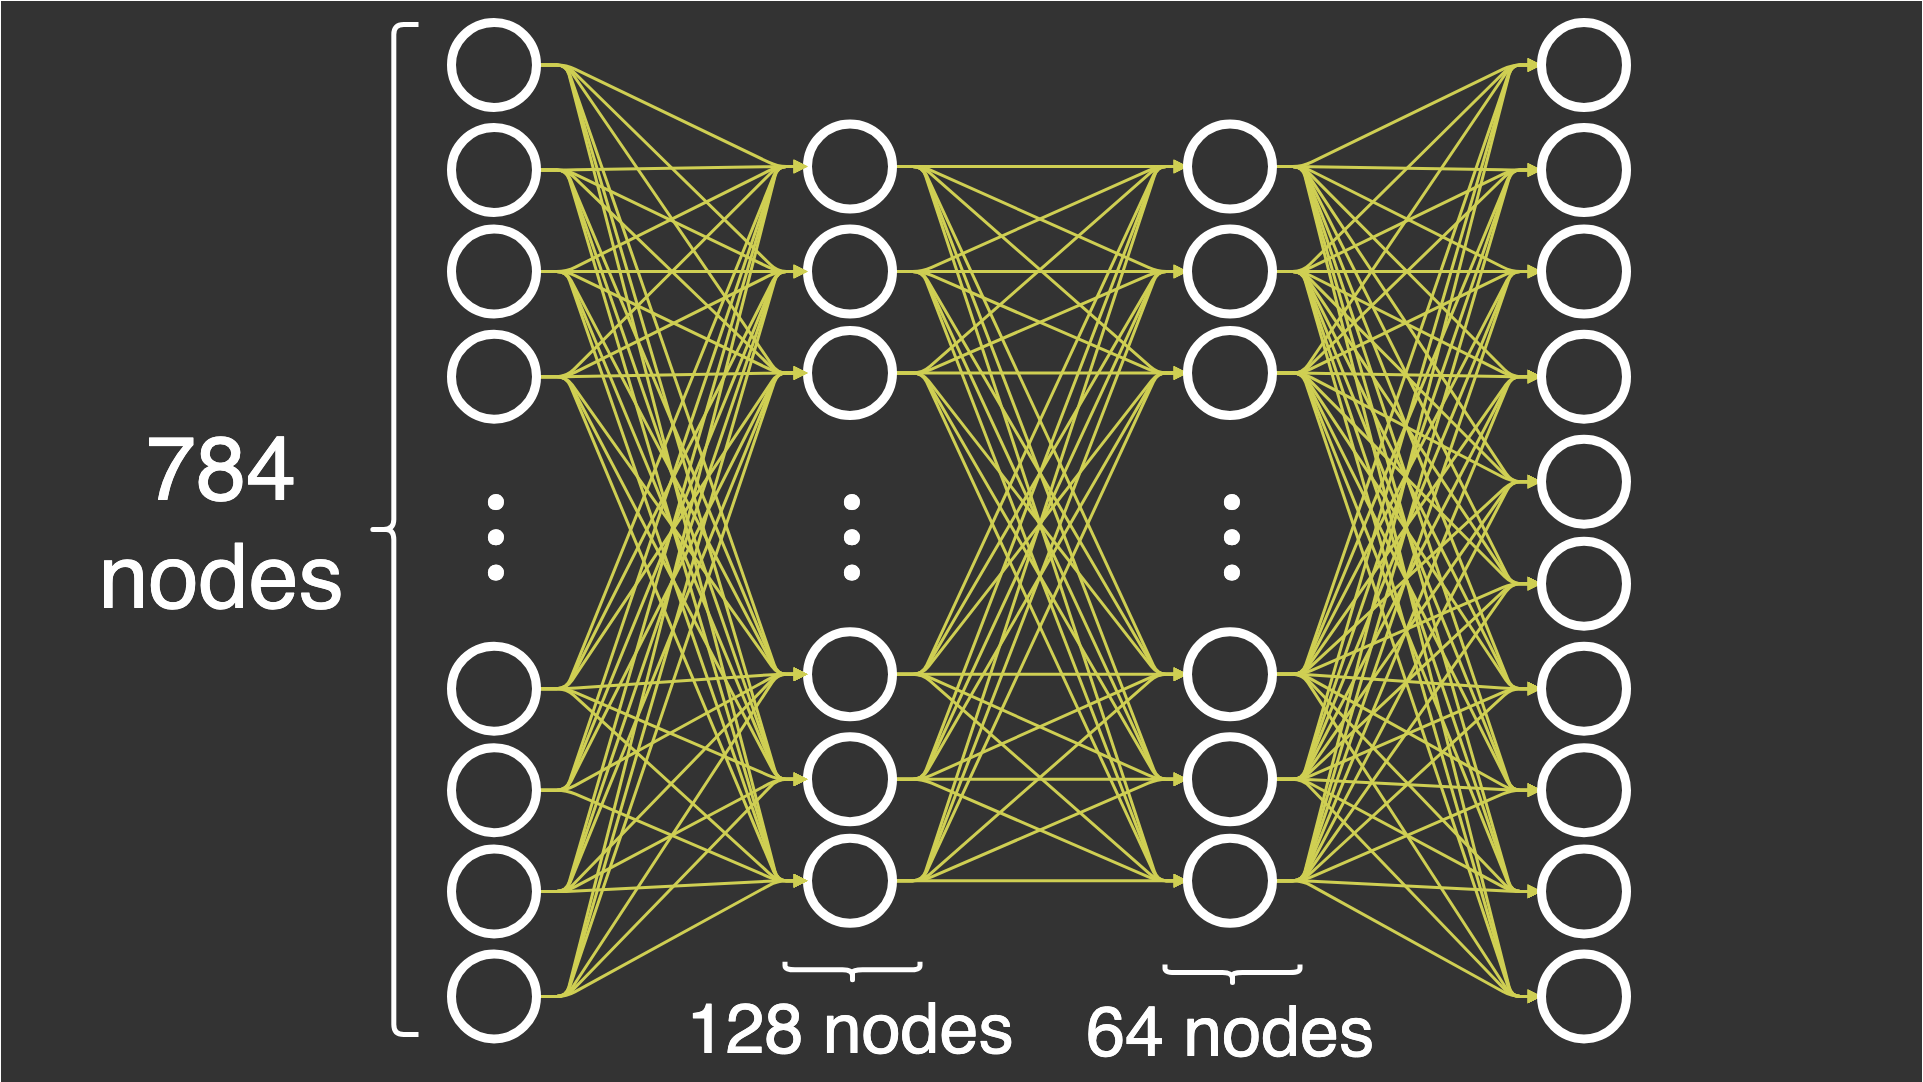

# NumPy

This is the hardest one to implement, since we will have to lay out most of the groundwork ourselves, for this approach to work. Comparatively, TensorFlow and PyTorch is much easier, which we will see later on.

## Choosing a Dataset

For this walkthrough, we will focus on importing the MNIST dataset and using that as the input to our deep neural networks. Note that this is purely a demonstration of how to make a neural network from scratch, and it is NOT the recommended architecture for solving the MNIST problem. We will reuse some code from one of the other articles on [Activation Functions Explained](https://mlfromscratch.com/activation-functions-explained/).

In [ ]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

Using TensorFlow backend.


## 4-layer Neural Network with NumPy

In [ ]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

### Results

Completely dependent on how the weights are initialized, we get different results. Sometimes we are stuck at 0% accuracy, sometimes 5-10%, other times it jumps from 22% to 94.5%. If you want to experiment, try using a seed for numpy by `np.random.seed(42)` or any other number. Then you should get the same results each time.

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 19.49s, Accuracy: 30.35%
Epoch: 2, Time Spent: 39.43s, Accuracy: 33.91%
Epoch: 3, Time Spent: 58.97s, Accuracy: 35.30%
Epoch: 4, Time Spent: 83.14s, Accuracy: 37.18%
Epoch: 5, Time Spent: 110.22s, Accuracy: 39.78%
Epoch: 6, Time Spent: 134.18s, Accuracy: 43.38%
Epoch: 7, Time Spent: 157.27s, Accuracy: 47.69%
Epoch: 8, Time Spent: 179.37s, Accuracy: 51.27%
Epoch: 9, Time Spent: 200.64s, Accuracy: 54.15%
Epoch: 10, Time Spent: 221.77s, Accuracy: 56.48%


## Exercises

These exercises could improve the network's performance. There are no solutions, but it's good to try and solve them to get better knowledge of how neural networks work.

1. **Easy**: Implement the ReLU activation function, or any other activation function from [this overview of activation functions](https://mlfromscratch.com/activation-functions-explained/). Check how the sigmoid functions are implemented for reference, and remember to implement the derivative as well. Use the ReLU activation function in place of the sigmoid function.

2. **Easy**: Initialize biases and add them to Z before the activation function in the forward pass, and update the biases in the backward pass.

3. **Medium**: Optimize the forward and backward pass, such that they run in a for-loop in each function. This makes the code easier to modify and possibly easier to maintain.
    - Optimize the initialization function that makes weights for the neural network, such that you can modify the `sizes=[]` argument without the neural network failing.

4. **Medium**: Implement mini-batch gradient descent, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64.

5. **Hard**: Implement the Adam optimizer, described in [this overview of optimizers](https://mlfromscratch.com/optimizers-explained). This should be implemented in the train function.
    - Implement Momentum by adding the extra term.
    - Implement an adaptive learning rate, based on the AdaGrad optimizer.
    - Use step a and b to finally implement Adam.

# PyTorch

PyTorch is yet another popular framework for computations, and this one is widely used in the research community. In PyTorch, you still have to do a lot of work yourself by aligning all the dimensions of the data and specifying the layers and forward pass in an exact manner. This is not a bad thing though, and it's much easier to customize components of a neural network.

## Loading MNIST with PyTorch

Importing with PyTorch is straight away more complicated than we saw previously. This was one of the things that threw me off at first, but it seems straight forward once you get what the DataLoader returns you, and how you can access the data in the objects.

In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform))

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transform))


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## 4-layer Neural Network With PyTorch

In [ ]:
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, epochs=10):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

        self.epochs = epochs

    def forward_pass(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        x = torch.softmax(x, dim=0)
        return x
    
    def one_hot_encode(self, y):
        encoded = torch.zeros([10], dtype=torch.float64)
        encoded[y[0]] = 1.
        return encoded

    def train(self, train_loader, optimizer, criterion):
        start_time = time.time()
        loss = None

        for iteration in range(self.epochs):
            for x,y in train_loader:
                y = self.one_hot_encode(y)
                optimizer.zero_grad()
                output = self.forward_pass(torch.flatten(x))
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

            print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(
                iteration+1, time.time() - start_time, loss
            ))

In [ ]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

model.train(train_loader, optimizer, criterion)

Epoch: 1, Time Spent: 84.44s, Loss: 0.7368985049426555
Epoch: 2, Time Spent: 170.03s, Loss: 0.7364664882421493
Epoch: 3, Time Spent: 254.10s, Loss: 0.7362075932323933
Epoch: 4, Time Spent: 338.68s, Loss: 0.7360569342970849
Epoch: 5, Time Spent: 423.33s, Loss: 0.7359708845615387
Epoch: 6, Time Spent: 506.73s, Loss: 0.7359219565987587
Epoch: 7, Time Spent: 589.02s, Loss: 0.7358960770070553
Epoch: 8, Time Spent: 675.11s, Loss: 0.7358882628381253
Epoch: 9, Time Spent: 757.60s, Loss: 0.7358985215425491
Epoch: 10, Time Spent: 841.95s, Loss: 0.7359289146959782


# TensorFlow 2.0 with Keras

Now that we know just how much code lies behind a simple neural network in NumPy and PyTorch, let's look at how easily we can construct the same network in TensorFlow (with Keras).

With TensorFlow and Keras, we don't have to think as much about activation functions, optimizers etc., since they are already implemented. On top of this, we will see huge improvements in the time it takes to execute and train a neural network, since the frameworks are completely optimized compared to NumPy.

The following approach goes for a complete Keras solution, without a custom training function or anything very TensorFlow related. Go to the end of my [TensorFlow 2.0 tutorial](https://mlfromscratch.com/tensorflow-2/#custom-train-and-test-functions-in-tensorflow-2-0) to see what a custom training function looks like.

In [ ]:
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 3.9MB 38.6MB/s 
     |████████████████████████████████| 450kB 38.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10)
])

model.compile(optimizer='SGD',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 86us/sample - loss: 3.7515 - acc: 0.7392
Epoch 2/10
60000/60000 [==============================] - 5s 85us/sample - loss: 3.6974 - acc: 0.7421
Epoch 3/10
60000/60000 [==============================] - 5s 87us/sample - loss: 3.5913 - acc: 0.7304
Epoch 4/10
60000/60000 [==============================] - 5s 87us/sample - loss: 4.6731 - acc: 0.6649
Epoch 5/10
60000/60000 [==============================] - 5s 85us/sample - loss: 5.7233 - acc: 0.6057
Epoch 6/10
60000/60000 [==============================] - 5s 82us/sample - loss: 7.3757 - acc: 0.5147
Epoch 7/10
60000/60000 [==============================] - 5s 84us/sample - loss: 7.3755 - acc: 0.5163
Epoch 8/10
60000/60000 [==============================] - 5s 84us/sample - loss: 7.3711 - acc: 0.5171
Epoch 9/10
60000/60000 [==============================] - 5s 84us/sample - loss: 7.3698 - acc: 0.5172
Epoch 10/10
60000/60000 [==============================] - 